In [1]:
from train import *
from test import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [2]:
data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test, \
otu_columns, domain_columns = read_data()

# Autoencoder Bioma Bioma

In [3]:
def model(shape, input_transform, output_transform, layers_list, latent_space, activation_fn):
    return autoencoder(domain_shape=None, 
                       bioma_layers=layers_list, 
                       latent_space=latent_space,
                       input_transform=input_transform,
                       output_transform=output_transform,
                       activation_function_encoder=activation_fn,
                       activation_function_decoder=activation_fn,
                       activation_function_latent=activation_fn)

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [4]:
latent_space = 100
def model_fn():
    m, e, _, d = model(shape=717,
                      input_transform=CenterLogRatio(),
                      output_transform=None,
                      layers_list=[256,128],
                      latent_space=latent_space,
                      activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, e, None, d

In [5]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>52</b></p>

<b>loss</b>: 1.9757 (min: 1.9657, max: 1.9862)

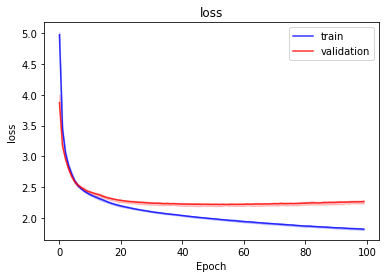

<b>bioma_BrayCurtis</b>: 0.2456 (min: 0.2438, max: 0.2482)

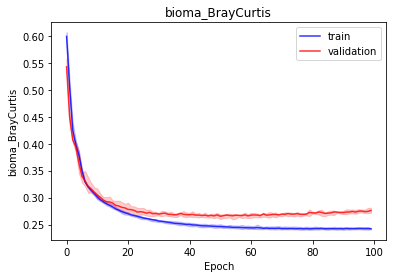

<b>bioma_pearson_corr</b>: 0.8717 (min: 0.8695, max: 0.8742)

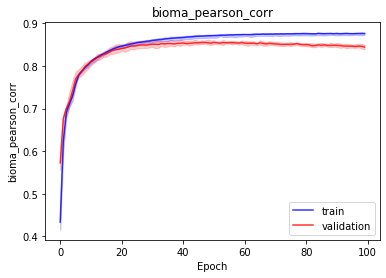

<b>bioma_jensen_shannon_divergence</b>: 0.3438 (min: 0.3364, max: 0.3536)

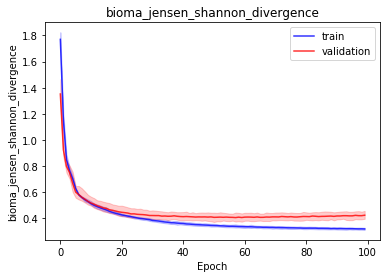

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.9757440392647783 | 1.965681440442564 | 1.9862340586706317 |
| bioma_BrayCurtis | 0.24561138451099396 | 0.24384845793247223 | 0.24820879101753235 |
| bioma_pearson_corr | 0.8717287182807922 | 0.8694902062416077 | 0.8741822242736816 |
| bioma_jensen_shannon_divergence | 0.3437556326389313 | 0.3364107012748718 | 0.35357004404067993 |


[('best_lost_epoch', 52),
 ('val_loss', [2.2175415328570773, 2.1894099031175887, 2.2345096383775984]),
 ('val_bioma_BrayCurtis', [0.26757613, 0.26231322, 0.26980957]),
 ('val_bioma_pearson_corr', [0.8532152, 0.850535, 0.85765135]),
 ('val_bioma_jensen_shannon_divergence', [0.41057095, 0.37774676, 0.44731036])]

In [6]:
print_results(results)

In [7]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = Percentage()(data_microbioma_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, model_encoder, _, _ = cv_models
        predictions = model.predict(data_microbioma_test)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        predictions = tf.nn.softmax(predictions)
        all_predictions.append(predictions)
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    
    return final_predictions

In [8]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_autoencoder_bioma.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2715207040309906 | 0.26995038986206055 | 0.27485036849975586 |
| pearson_corr | 0.8438930511474609 | 0.8405015468597412 | 0.8474021553993225 |
| jensen_shannon_divergence | 0.37838488817214966 | 0.36391523480415344 | 0.38616740703582764 |


### Best Otus
| OTU | mse |
|:----|----:|
| 883748 | 1.0016643514632051e-08 |
| 238109 | 1.006359173771898e-08 |
| 555384 | 1.0098180958095782e-08 |
| 510316 | 1.0110101200666577e-08 |
| 1028953 | 1.0110307258059947e-08 |
| 242284 | 1.0112856330124487e-08 |
| 584331 | 1.0115242865538221e-08 |
| 769643 | 1.0115963178236598e-08 |
| 606989 | 1.013425965368242e-08 |
| 11428 | 1.014566386459137e-08 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.02027338556945324 |
| 961783 | 0.004039101302623749 |
| 4339351 | 0.003261299105361104 |
| 849156 | 0.000620533071924001 |
| 573135 | 0.0005905063007958233 |
| 339660 | 0.00045568839414045215 |
| 527397 | 0.0004093227908015251 |
| 353494 | 0.00039096930413506925 |
| 570086 | 0.00036878089304082096 |
| 1060517 | 0.00033770810114219785 |


In [9]:
encoders = []
decoders = []
for cv_models in models:
    model, encoder, _, decoder = cv_models
    encoders.append(encoder)
    decoders.append(decoder)
    
def make_cv_predictions(data, models):
    all_predictions = []
    for m in models:
        all_predictions.append(m.predict(data))
    return np.mean(all_predictions, axis=0)

# Single regresión from domain to encoded latent space

In [10]:
target_data = make_cv_predictions(data_microbioma_train, encoders)
test_data = make_cv_predictions(data_microbioma_test, encoders)

In [11]:
def model_fn():
    in_layer = layers.Input(shape=(36,))
    net = layers.Dense(128, activation=None)(in_layer)
    out_layer = layers.Dense(100, activation=None)(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError())
    return model

In [12]:
def train_2(model_fn,
          data_encoded,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          random_seed=347,
          verbose=0):
    kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    for train_index, test_index in kf.split(data_domain):
        y_train, y_test = data_encoded[train_index], data_encoded[test_index]
        x_train, x_test = data_domain[train_index], data_domain[test_index]
        model = model_fn()
        metrics_prefix = 'domain'

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
        train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        r = model.fit(train_dataset,
                      epochs=epochs,
                      validation_data=val_dataset,
                      callbacks=train_callbacks,
                      verbose=0)
        if metrics_prefix is not None:
            old_keys = r.history
            r.history = {}
            for k, v in old_keys.items():
                if k == 'loss' or k == 'val_loss':
                    new_key = k
                elif k.startswith('val_'):
                    new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
                else:
                    new_key = '{}_{}'.format(metrics_prefix, k)
                r.history[new_key] = v
        results.append(r)
        models.append(model)
    return results, models

In [13]:
results, models = train_2(model_fn,
                        target_data,
                        data_domain_train,
                        latent_space=100,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        verbose=-1)

<p>Best iteration: <b>24</b></p>

<b>loss</b>: 0.0676 (min: 0.0671, max: 0.0681)

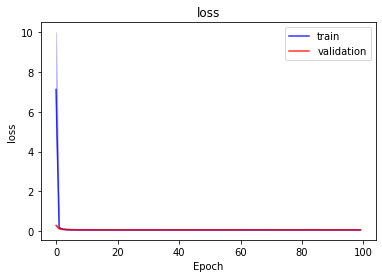

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.06761070923673064 | 0.06710136827300577 | 0.06805659373589594 |


[('best_lost_epoch', 24),
 ('val_loss', [0.06921735757163591, 0.06782390230468341, 0.07035436161926814])]

In [14]:
print_results(results)

In [15]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = Percentage()(data_microbioma_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for model in models:
        predictions = model.predict(data_domain_test)
        all_predictions.append(predictions)
    final_predictions = np.mean(all_predictions,axis=0)
    
    final_decoded = make_cv_predictions(final_predictions, decoders)
    predictions = tf.nn.softmax(final_decoded)
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(data_microbioma_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    return predictions

In [16]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_domain_to_encoded_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4659050703048706 | 0.4659050703048706 | 0.4659050703048706 |
| pearson_corr | 0.6461873650550842 | 0.6461873650550842 | 0.6461873650550842 |
| jensen_shannon_divergence | 1.0585098266601562 | 1.0585098266601562 | 1.0585098266601562 |


### Best Otus
| OTU | mse |
|:----|----:|
| 1084157 | 0.031803976744413376 |
| 547097 | 0.05222408473491669 |
| 654742 | 0.05473138391971588 |
| 564004 | 0.05530620738863945 |
| 664216 | 0.0613853745162487 |
| 1131545 | 0.06295857578516006 |
| 676066 | 0.07100063562393188 |
| 859157 | 0.07174476236104965 |
| 142233 | 0.07535035908222198 |
| 1105574 | 0.07916140556335449 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 66.89363098144531 |
| 961783 | 41.4505729675293 |
| 339660 | 37.952632904052734 |
| 527397 | 35.38346481323242 |
| 573135 | 31.635351181030273 |
| 4339351 | 27.926227569580078 |
| 822874 | 26.71384048461914 |
| 539866 | 26.655967712402344 |
| 541511 | 24.987470626831055 |
| 365415 | 24.480104446411133 |


# Domain-Bioma 

In [17]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation=None)(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [18]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128,256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [19]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>57</b></p>

<b>loss</b>: 3.7580 (min: 3.7498, max: 3.7647)

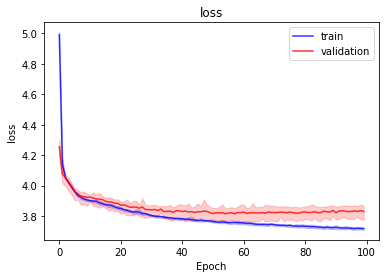

<b>domain_BrayCurtis</b>: 0.4119 (min: 0.4090, max: 0.4138)

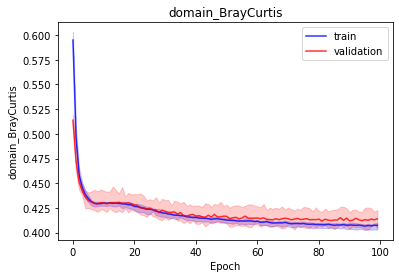

<b>domain_pearson_corr</b>: 0.7265 (min: 0.7232, max: 0.7301)

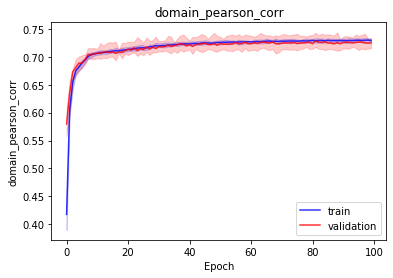

<b>domain_jensen_shannon_divergence</b>: 0.8796 (min: 0.8601, max: 0.8961)

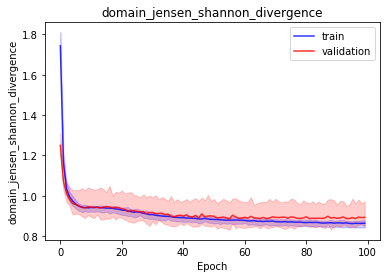

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7579967506929988 | 3.749819547139487 | 3.7647073588651767 |
| domain_BrayCurtis | 0.41186824440956116 | 0.4090002477169037 | 0.4138478934764862 |
| domain_pearson_corr | 0.7265396118164062 | 0.7232087850570679 | 0.7300570011138916 |
| domain_jensen_shannon_divergence | 0.8796180486679077 | 0.8600585460662842 | 0.8961083889007568 |


[('best_lost_epoch', 57),
 ('val_loss', [3.815086044584002, 3.76842771257673, 3.8517206055777415]),
 ('val_domain_BrayCurtis', [0.41455618, 0.4056124, 0.428448]),
 ('val_domain_pearson_corr', [0.72362787, 0.7088155, 0.7361102]),
 ('val_domain_jensen_shannon_divergence', [0.89482164, 0.8372363, 0.98748505])]

In [20]:
print_results(results)

In [21]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = Percentage()(data_microbioma_test)
    if input_transform is not None:
        input_transform = input_transform()
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(data_domain_test)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        predictions = tf.nn.softmax(predictions)
        all_predictions.append(predictions)
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [22]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4159122109413147 | 0.41300323605537415 | 0.4209136664867401 |
| pearson_corr | 0.7259584665298462 | 0.7154849767684937 | 0.7305828332901001 |
| jensen_shannon_divergence | 0.8394817113876343 | 0.8233330845832825 | 0.8603849411010742 |


### Best Otus
| OTU | mse |
|:----|----:|
| 769643 | 3.942008611895753e-12 |
| 11428 | 4.00820479237729e-12 |
| 833317 | 4.020606330507048e-12 |
| 555384 | 4.0286723609894715e-12 |
| 585221 | 4.057203357998862e-12 |
| 238109 | 4.067971653975988e-12 |
| 242284 | 4.09676936471981e-12 |
| 137818 | 4.138301246819909e-12 |
| 883748 | 4.157482084293784e-12 |
| 810679 | 4.257062584389626e-12 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.061720676720142365 |
| 961783 | 0.009259438142180443 |
| 4339351 | 0.005310836248099804 |
| 849156 | 0.0007628820603713393 |
| 527397 | 0.0007588197477161884 |
| 573135 | 0.0006594348815269768 |
| 353494 | 0.00049288768786937 |
| 339660 | 0.0004829871468245983 |
| 570086 | 0.00040050302050076425 |
| 1060517 | 0.0003429079370107502 |


# Autoencoder-like from domain

In [23]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128, 100, 128, 256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio(),
                  output_transform=None)
    return m, None, m, None

In [24]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>44</b></p>

<b>loss</b>: 3.7689 (min: 3.7625, max: 3.7863)

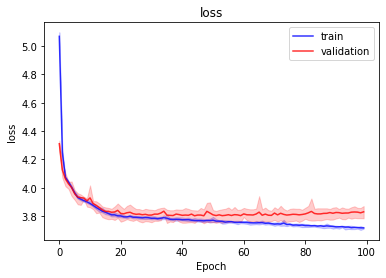

<b>domain_BrayCurtis</b>: 0.4100 (min: 0.4065, max: 0.4116)

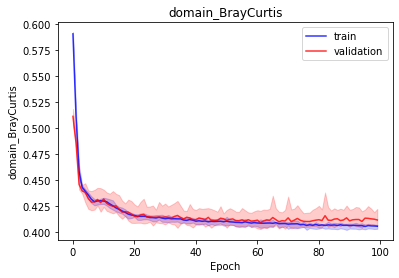

<b>domain_pearson_corr</b>: 0.7276 (min: 0.7242, max: 0.7325)

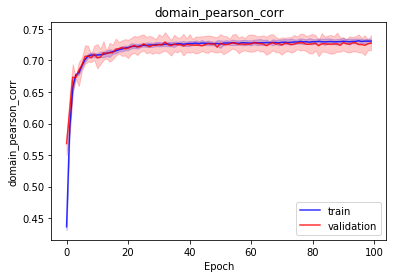

<b>domain_jensen_shannon_divergence</b>: 0.8761 (min: 0.8548, max: 0.8891)

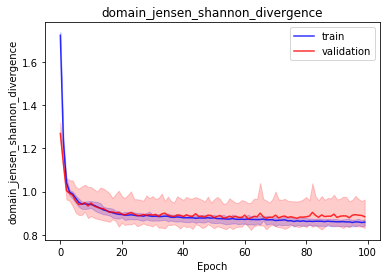

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7689280467476514 | 3.7625014019937804 | 3.786265390059527 |
| domain_BrayCurtis | 0.4099923074245453 | 0.4064989984035492 | 0.4115598201751709 |
| domain_pearson_corr | 0.7275606989860535 | 0.7242007851600647 | 0.7325308322906494 |
| domain_jensen_shannon_divergence | 0.8761096000671387 | 0.8548203110694885 | 0.8890647292137146 |


[('best_lost_epoch', 44),
 ('val_loss', [3.8022494384220673, 3.7518540961401805, 3.8405040502548218]),
 ('val_domain_BrayCurtis', [0.41426975, 0.40697014, 0.42310098]),
 ('val_domain_pearson_corr', [0.72316563, 0.7150068, 0.7382434]),
 ('val_domain_jensen_shannon_divergence', [0.89740866, 0.8472431, 0.97422177])]

In [25]:
print_results(results)

In [26]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_fake_domain_autoencoder.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4148046374320984 | 0.4128890931606293 | 0.41636577248573303 |
| pearson_corr | 0.7307088971138 | 0.7287275195121765 | 0.7326630353927612 |
| jensen_shannon_divergence | 0.8370887041091919 | 0.8271368741989136 | 0.8466781377792358 |


### Best Otus
| OTU | mse |
|:----|----:|
| 242284 | 6.6845765034351246e-12 |
| 238109 | 6.73673833731514e-12 |
| 216643 | 6.880127110392431e-12 |
| 769643 | 6.885233268943969e-12 |
| 584331 | 6.9864574195332985e-12 |
| 11428 | 7.0058993328903085e-12 |
| 833317 | 7.049979957457486e-12 |
| 137818 | 7.0578798881670846e-12 |
| 883748 | 7.080119910490845e-12 |
| 810679 | 7.14104816945671e-12 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 646549 | 0.058098576962947845 |
| 961783 | 0.00931690912693739 |
| 4339351 | 0.005074069369584322 |
| 849156 | 0.0007629023166373372 |
| 527397 | 0.0007563772378489375 |
| 573135 | 0.0006783832795917988 |
| 353494 | 0.0004931669100187719 |
| 339660 | 0.00046034809201955795 |
| 570086 | 0.0003965332289226353 |
| 1060517 | 0.00033759180223569274 |
